### You can go through the below resources to better understand the concept of DCGAN:
- <b><a href = "https://github.com/Pi-Akash/Pytorch-Learnings/blob/main/SimpleGAN.ipynb">Basic Understanding of GANs</a></b>
- <b><a href = "https://www.youtube.com/watch?v=IZtv9s_Wx9I&list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&index=3&t=1405s">Aladdin Persson, DCGAN Implementation from Scratch</a></b>
- <b><a href = "https://arxiv.org/abs/1511.06434">DCGAN Original Paper</a></b>
- <b><a href = "https://www.programmersought.com/article/66075375215/">Understanding Convolution and Deconvolution in PyTorch</a></b>


### General Idea behind GANS

<b>The overall architecture of GANS consists of two deep learning models namely Generator and Discriminator. For every Iteration or Epoch Generator tries to create an output (in this case images, can be applied to any linear, non-linear functions outputs or non-structured data) in turn, the discriminator will try to differentiate between the true data and the outputs from Generator.</b>

<b>After a few iterations/Epochs ideally the Discriminator should face some difficulty in differentiating the true images and the generated ones that means we want to maximize the loss for Discriminator. At the same time we want our Generator to be able to generate better data so that the outputs will be hard to differentiate for discriminator that means we want to minimize the loss function for our Generator.</b>

<b>Lets start with above learning in mind:</b>

In [1]:
# importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
# path where my resources are in local
path = "D:/Datasets/GANS"
os.chdir(path)

In [3]:
# hyperparameters and variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4 # as per the original paper
BATCH_SIZE = 64
IMAGE_SIZE = 64
NOISE_DIM = 100 # as per the original paper
NUM_EPOCH = 10
IMG_CHANNELS = 3
DEBUGGING = True

In [4]:
# a few modifications to the dataset
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), # resize the image to 64 pixels
    transforms.ToTensor(), # convert image to tensors
    transforms.Normalize(
        [0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]
    ),
])

In [5]:
#BATCH_SIZE = 32
# the dataset is downloadable from here: https://www.kaggle.com/cactus3/basicshapes
dataset = datasets.ImageFolder('Shapes/training_set', transform = transform)
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

In [6]:
print("loader length = ", len(loader))
example_images, example_targets = next(iter(loader))

loader length =  5


In [7]:
example_images.shape, example_targets.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [8]:
# other hyperparameters and variables
IMG_CHANNELS = example_images.shape[1]

In [9]:
def plot_images(images):
    #print("Images dimensions : ",images.shape)
    imgs = torchvision.utils.make_grid(images)
    np_imgs = imgs.numpy()
    
    plt.figure(figsize = (12,6))
    plt.imshow(np.transpose(np_imgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


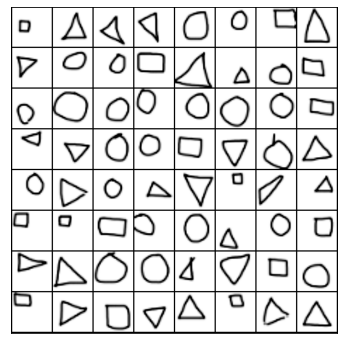

In [10]:
plot_images(example_images)

### Generator and Discriminator Model

<b>Lets start with Generator and Discriminator for our model, we will follow the architecture given in the below image.</b>

<img src = "Resources/DCGAN.png">

### Generator Model

In [11]:
class Generator(nn.Module):
    def __init__(self, generator_img_dim, img_channels, output_img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            # Input = batch_size * generator_img_dim * 1 * 1
            
            # the very first layer/block for generator.
            # output_img_dim = 64
            # we want the output from first block to be 4*4*1024
            # out_channels = 1024 = output_img_dim * 16
            nn.ConvTranspose2d(
                in_channels = generator_img_dim,
                out_channels = output_img_dim * 16,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False,
            ),
            nn.ReLU(),
            
            # second block for generator
            # output from previous block = 1024
            # we want the output from second block to be 8*8*512
            # out channels = 512 = output_img_dim * 8
            nn.ConvTranspose2d(
                in_channels = output_img_dim * 16,
                out_channels = output_img_dim * 8,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False,
            ),
            nn.ReLU(),
            
            # third block for generator
            # output from previous block = 512
            # we want the output from third block to be 16*16*256
            # out channels = 256 = output_img_dim * 4
            nn.ConvTranspose2d(
                in_channels = output_img_dim * 8,
                out_channels = output_img_dim * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False,
            ),
            nn.ReLU(),
            
            # fourth block for generator
            # output from previous block = 256
            # we want the output from fourth block to be 32*32*128
            # out channels = 128 = output_img_dim * 2
            nn.ConvTranspose2d(
                in_channels = output_img_dim * 4,
                out_channels = output_img_dim * 2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.ReLU(),
            
            # fifth block for generator
            # output from previous block = 128
            # we want the output from fifth block to be 64*64*3
            nn.ConvTranspose2d(
                in_channels = output_img_dim * 2,
                out_channels = img_channels,
                kernel_size = 4,
                stride = 2,
                padding = 1
            ),
            # we have normalized the image at first therefore,
            # we want our outputs to be in the same range as that of after normalization
            # tanh ranges from (-1, 1) which is same as our output from Normalize function.
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
# lets see how our generator performs on an example data
print("Generator Sanity check")
example_input = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1)
print("Example Input shape : ", example_input.shape)
Gen = Generator(NOISE_DIM, IMG_CHANNELS, IMAGE_SIZE).to(DEVICE)
example_output = Gen(example_input)
print("Example Output shape : ", example_output.shape)

Generator Sanity check
Example Input shape :  torch.Size([64, 100, 1, 1])
Example Output shape :  torch.Size([64, 3, 64, 64])


### Discriminator Model

In [13]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input : Batch_size * img_channels * image_size * image_size
            
            # first block of discriminator
            # we want the output from first block to be 32*32*64
            # out_channels = img_size
            nn.Conv2d(
                in_channels = img_channels,
                out_channels = image_size,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.LeakyReLU(0.2), # as per the paper
            
            # second block of discriminator
            # output from first block = 32*32*64
            # we want the output from second block to be 16*16*128
            # out_channels = img_size * 2
            nn.Conv2d(
                in_channels = image_size,
                out_channels = image_size * 2,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False,
            ),
            nn.LeakyReLU(0.2),
            
            # third block of discriminator
            # output from second block = 16*16*128
            # we want the output from third block to be 8*8*256
            # out_channels = img_size * 4
            nn.Conv2d(
                in_channels = image_size * 2,
                out_channels = image_size * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False,
            ),
            nn.LeakyReLU(0.2),
            
            # fourth block of discriminator
            # output from third block = 8*8*256
            # we want the output from fourth block to be 4*4*512
            # out channels = img_size * 8
            nn.Conv2d(
                in_channels = image_size * 4,
                out_channels = image_size * 8,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False,
            ),
            nn.LeakyReLU(0.2),
            
            # we want the discriminator to output a single probability value.
            # the value should be between 0 and 1.
            # therefore the value from above block will be converted to a 1*1 value.
            # in the below block
            nn.Conv2d(
                in_channels = image_size * 8,
                out_channels = 1,
                kernel_size = 4,
                stride = 2,
                padding = 0,
            ),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

In [14]:
print("Discriminator Sanity Check")
print("Example input shape : ", example_images.shape)
Disc = Discriminator(IMG_CHANNELS, IMAGE_SIZE).to(DEVICE)
example_output = Disc(example_images).reshape(BATCH_SIZE, -1)
print("Example output shape : ", example_output.shape)
print()
print("Output from Discriminator :")
print(example_output)

Discriminator Sanity Check
Example input shape :  torch.Size([64, 3, 64, 64])
Example output shape :  torch.Size([64, 1])

Output from Discriminator :
tensor([[0.4996],
        [0.5000],
        [0.4982],
        [0.5005],
        [0.4968],
        [0.4971],
        [0.4980],
        [0.4996],
        [0.4993],
        [0.4979],
        [0.4992],
        [0.4998],
        [0.4996],
        [0.4994],
        [0.4992],
        [0.5011],
        [0.5000],
        [0.4980],
        [0.4971],
        [0.4994],
        [0.4993],
        [0.5007],
        [0.4979],
        [0.4980],
        [0.4996],
        [0.5000],
        [0.4986],
        [0.5016],
        [0.5014],
        [0.4987],
        [0.4977],
        [0.4983],
        [0.5007],
        [0.4996],
        [0.5001],
        [0.4994],
        [0.4994],
        [0.4989],
        [0.4998],
        [0.4982],
        [0.5001],
        [0.5005],
        [0.4995],
        [0.4996],
        [0.4985],
        [0.4986],
        [0.5002],
   

<b>In the DCGAN paper they have initialized the starting model weights to be mean 0 and std dev. 0.02. we are going to do the same in the below function.</b>

In [15]:
def initial_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [16]:
# initializing model class objects
generator = Generator(NOISE_DIM, IMG_CHANNELS, IMAGE_SIZE).to(DEVICE)
discriminator = Discriminator(IMG_CHANNELS, IMAGE_SIZE).to(DEVICE)

In [17]:
# initializing weights to model class objects
initial_weights(generator)
initial_weights(discriminator)

In [18]:
# initialiing optimizers
gen_opt = optim.Adam(generator.parameters(), lr = LEARNING_RATE)
disc_opt = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE)

In [19]:
# Input noise to test our GAN after every few epochs
FIXED_NOISE = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(DEVICE)

In [20]:
global counter
counter = 1
def debug():
    global counter
    print("Iteration {} completed".format(counter))
    counter += 1

Epoch : 1, Gen loss : 0.6426343798637391, Disc loss : 1.0980274200439453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


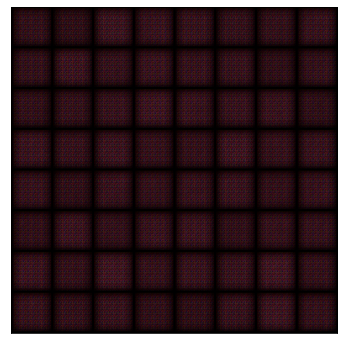



Epoch : 3, Gen loss : 1.2769830822944641, Disc loss : 1.2665643453598023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


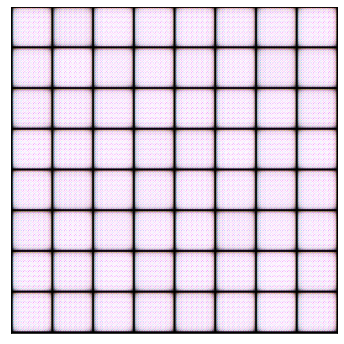



Epoch : 5, Gen loss : 0.924748694896698, Disc loss : 1.302593994140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


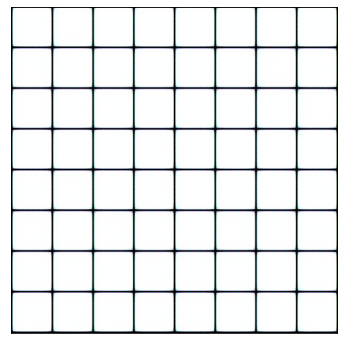



Epoch : 7, Gen loss : 0.9161003708839417, Disc loss : 1.1725828886032104


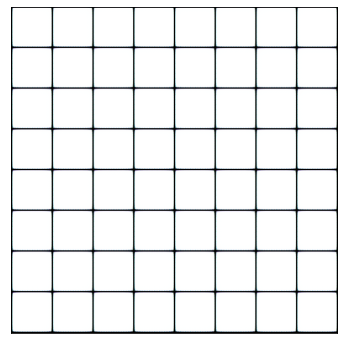



Epoch : 9, Gen loss : 1.4179783463478088, Disc loss : 0.7637978434562683


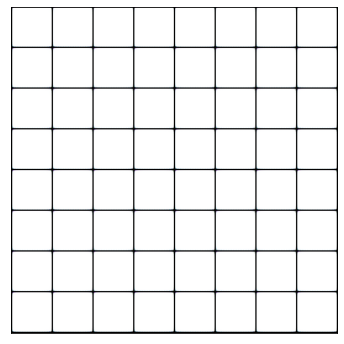

In [21]:
# training loop
NUM_EPOCH = 10
DEBUGGING = False
for epoch in range(NUM_EPOCH):
    # setting initial loss values before every epoch
    gen_loss_run = 0.0
    disc_loss_run = 0.0
    if DEBUGGING == True:
        print("-- Initialized loss for epoch {}".format(epoch))
    
    for batch_idx, data in enumerate(loader):
        Real, _ = data
        batch_size = Real.shape[0]
        
        #FORWARD PROPAGATION FOR DISCRIMINATOR
        # true labels to match with real images during loss calculation
        one_labels = torch.ones(batch_size, 1)
        
        # false labels to match with fake images during loss calculation
        zero_labels = torch.zeros(batch_size, 1)
        
        # generating noise, input for generator
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1).to(DEVICE)
        
        # discriminator returns a value between 0 and 1 for all the inputs in a batch
        discriminator_real = discriminator(Real)
        discriminator_fake = discriminator(generator(noise))
        
        # converting shape of output from discriminator same as that of one labels
        discriminator_real = discriminator_real.reshape(batch_size,-1)
        discriminator_fake = discriminator_fake.reshape(batch_size, -1)
        
        # cross entropy loss for real images
        discriminator_real_loss = F.binary_cross_entropy(discriminator_real, one_labels)
        # cross entropy loss for fake images
        discriminator_fake_loss = F.binary_cross_entropy(discriminator_fake, zero_labels)
        # total loss for discriminator
        net_discriminator_loss = discriminator_real_loss + discriminator_fake_loss
        
        if DEBUGGING == True:
            print("-- Discriminator: Forward propagation completed.")
        
        # BACKWARD PROPAGATION FOR DISCRIMINATOR
        disc_opt.zero_grad()
        net_discriminator_loss.backward()
        disc_opt.step()
        
        if DEBUGGING == True:
            print("-- Discriminator: Backward propagation completed.")
        
        # FORWARD PROPAGATION FOR GENERATOR
        # we have already created noise above so we are going to use that 
        discriminator_fake = discriminator(generator(noise))
        discriminator_fake = discriminator_fake.reshape(batch_size, -1)
        
        net_generator_loss = F.binary_cross_entropy(discriminator_fake, one_labels)
        
        if DEBUGGING == True:
            print("-- Generator: Forward propagation completed.")
        
        # BACKWARD PROPAGATION FOR GENERATOR
        gen_opt.zero_grad()
        net_generator_loss.backward()
        gen_opt.step()
        
        if DEBUGGING == True:
            print("-- Generator: Backward propagation completed.")
        
        gen_loss_run += net_generator_loss.item()
        disc_loss_run += net_discriminator_loss.item()
        
        #break
        #debug()
        
    if epoch % 2 == 0:
        print("Epoch : {}, Gen loss : {}, Disc loss : {}".format(epoch+1, gen_loss_run/(batch_idx+1), disc_loss_run/(batch_idx+1)))
        
        sample_fake = generator(FIXED_NOISE).detach()
        sample_real = data[0]
        
        plot_images(sample_fake)
        #plot_images(sample_real)
    print()

<b>We can see above that our code works and tries to create a better image similar to our input images. I have only ran the training loop for 10 epochs, running the code for a few 100 epochs can give much better outputs.</b>